# Custom Model

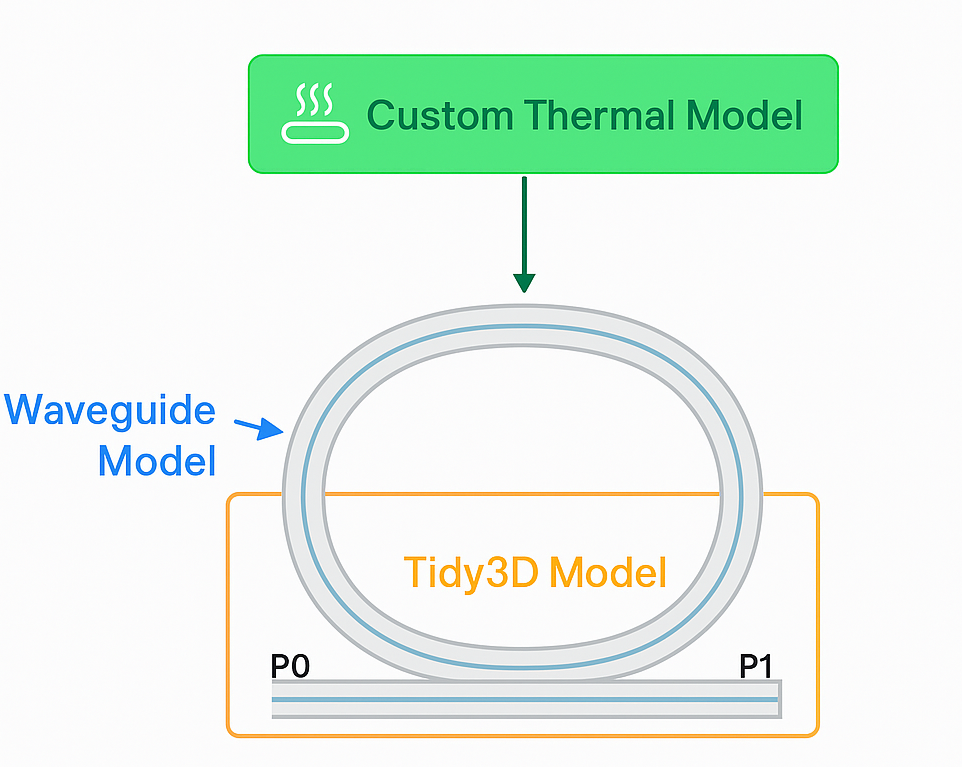


PhotonForge provides a [large number of models](../models.rst), particularly for passive optical devices.
However, custom models can be easily implemented for specific use-cases.
This short guide provides an example of custom model implementation for a voltage-controlled phase-shifter, that could be used in the [Tunable MZI](../examples/Tunable_MZI.ipynb) and the [Switch Array](../examples/Switch_Array.ipynb) examples.

The phase-shifter is based on a [WaveguideModel](../_autosummary/photonforge.WaveguideModel.rst) with propagation index modeled as:

$$
n_{\text{eff}}(V) = n_{\text{eff},0} + \gamma V^2
$$

in which $V$ is the applied voltage, $\gamma$ is a coefficient that relates the variation of the index with the squared voltage.

This model could be applied to a thermo-optic phase-shifter, where the temperature in the thermal element is proportional to the input electrical power (thus squared voltage) and the coefficient depends on the overall geometry and materials.
It can be calculated using a heat simulation, but we will skip that step to keep this guide short.

Any custom model must implement a few abstract methods from the [base Model class](../_autosummary/photonforge.Model.rst).
We will implement them one-by-one to provide a full reference for other models, but the source code for all PhotonForge models is also available in our docs.

In [1]:
import json
import struct

import numpy as np
import photonforge as pf

## Class initialization

The `__init__` method must call `super().__init__` with **all** user-provided arguments.
That ensures the `parametric_kwargs` attribute of all instances is properly initialized and they can be later used as parametric models and updated when necessary.

## Copying

The `__copy__` method must return a copy of the current model instance.
The `__deepcopy__` is similar, but it must ensure that all internal variables are also deep-copies (i.e. not references to the same original objects).
The [copy](https://docs.python.org/3/library/copy.html) module can be used to guarantee that.

## String representations

Although not strictly required, the `__str__` and `__repr__` methods can be implemented to provide better usability for the custom class.
`__str__` should return an informative, simple string representation of the object, whereas `__repr__` should, if possible, provide a representation that could be copied to recreate the original object.

## Byte representation

The instance property `as_bytes` and the class method `from_bytes` are used for serialization and de-serialization of the custom model instances.
The former has to encode the full object into a byte-string, including all attribute and internal state values required to reconstruct it.
The latter must do the reconstruction from the byte-string representation.

It is usually a good idea to include a version number in case the byte-representation changes in a future version and we want to have backwards compatibility.

A few libraries can be used to facilitate this process.
If all data can be encoded as json, using `json.dumps` and `json.loads` from the [json module](https://docs.python.org/3/library/json.html) can be an easy solution:

In [2]:
# Encode the object's data into a byte string
my_data = {
    "attribute1": "some value",
    "attribute2": 1234,
}

byte_data = json.dumps(my_data).encode("utf-8")

# Version as the first byte (version 0 in this case)
byte_repr = b"\x00" + byte_data

print(byte_repr)

b'\x00{"attribute1": "some value", "attribute2": 1234}'


In [3]:
# Decode the byte string back to the original data
version = byte_repr[0]
assert version == 0  # We could support several versions with this

decoded_data = json.loads(byte_repr[1:])
print(decoded_data)

{'attribute1': 'some value', 'attribute2': 1234}


Other options would be to use the [pickle module](https://docs.python.org/3/library/pickle.html) in a similar fashion, or the lower-level [struct module](https://docs.python.org/3/library/struct.html), as demonstrated in the actual implementation for this model.

## S-matrix computation

Lastly, we must provide a way for our custom model to actually compute the S matrix for a given component.
That is done in the `start` method.

The `start` method will receive keyword arguments passed to call to the [model](../_autosummary/photonforge.Model.rst#photonforge.Model.s_matrix) or [component](../_autosummary/photonforge.Component.rst#photonforge.Component.s_matrix) `s_matrix` method through the `model_kwargs` argument.
For this model, we want to accept a voltage value that overrides the internal voltage and allows us to set it dynamically.

For this model, we will leverage the existing [WaveguideModel](../_autosummary/photonforge.WaveguideModel.rst) to perform the actual computation based on the calculated propagation constant.

Alternatively, we could perform the computation in the function itself and return a [ModelResult](../_autosummary/photonforge.ModelResult.rst) with the computed S matrix.
If the computation is a long process, the `start` method can be used to simply kick it off and return an object that can be used to monitor the computation progress, but that will be left for another guide.

## Full implemetation

Putting it all together, we have the following implementation.

It is paramount to [register](../_autosummary/photonforge.register_model_class.rst) the custom model class after creating it, otherwise PhotonForge won't be able to use it automatically.

In [4]:
class ThermalModel(pf.Model):
    def __init__(self, n_complex, voltage=0, coefficient=3e-4):
        super().__init__(
            n_complex=n_complex,
            voltage=voltage,
            coefficient=coefficient,
        )
        self.n_complex = np.array(n_complex, ndmin=2)
        self.voltage = voltage
        self.coefficient = coefficient

    def __copy__(self):
        return ThermalModel(self.n_complex, self.voltage, self.coefficient)

    def __deepcopy__(self, memo=None):
        # n_complex is an array, so we want to make sure to create a deep copy of it.
        # Other values (voltage and coefficient) are immutable (floats), so we can use them directly.
        return ThermalModel(self.n_complex.copy(), self.voltage, self.coefficient)

    def __repr__(self):
        return f"ThermalModel({self.n_complex!r}, {self.voltage!r}, {self.coefficient!r})"

    def __str__(self):
        return f"ThermalModel at {self.voltage} V"

    @property
    def as_bytes(self):
        coeffs = struct.pack("<2d", self.voltage, self.coefficient)
        shape = struct.pack("<2l", *self.n_complex.shape)
        n_data = self.n_complex.astype(complex).tobytes()
        # Add version 0 as first byte
        return b"\x00" + coeffs + shape + n_data

    @classmethod
    def from_bytes(cls, byte_repr):
        version = byte_repr[0]
        if version != 0:
            raise RuntimeError(f"Incompatible version for ThermalModel: {version}")

        byte_repr = byte_repr[1:]
        fmt = "<2d2l"
        head_len = struct.calcsize(fmt)
        voltage, coefficient, rows, cols = struct.unpack(fmt, byte_repr[:head_len])

        byte_repr = byte_repr[head_len:]
        n_complex = np.frombuffer(byte_repr, dtype=complex).reshape((rows, cols))

        return cls(n_complex, voltage, coefficient)

    @pf.cache_s_matrix
    def start(self, component, frequencies, voltage=None, **kwargs):
        # Allow overriding voltage as an `s_matrix` kwarg too
        if voltage is None:
            voltage = self.voltage
        n_complex = self.n_complex + self.coefficient * voltage**2
        wg_model = pf.WaveguideModel(n_complex)
        return wg_model.start(component, frequencies, **kwargs)


pf.register_model_class(ThermalModel)

## Usage Example: Tunable Microring Resonator

We start by configuring the simulation environment

- We assign the basic photonforge technology to `pf.config.default_technology`.  
- We define default keyword arguments for our components, specifying a `"Strip"` port and a radius of `10`.  
- We define the wavelength range.  


In [5]:
import matplotlib.pyplot as plt
from photonforge.live_viewer import LiveViewer

viewer = LiveViewer(port=5013)

# Set default technology to the basic technology provided by photonforge
pf.config.default_technology = pf.basic_technology()

# Set default keyword arguments for simulations: use Strip port specification and radius of 10
pf.config.default_kwargs = {"port_spec": "Strip", "radius": 10}

# Define wavelength range for the simulation (in micrometers)
wavelengths = np.linspace(1.546, 1.548, 201)

# Convert wavelengths to frequencies (Hz) using speed of light constant
frequencies = pf.C_0 / wavelengths

Starting live viewer at http://localhost:5013


### Coupler Definition

We now define the directional coupler that will be used to couple light into and out of the microring:

- We create a dual-ring directional coupler with a waveguide gap of `0.9 µm` and a coupling region length of `10 µm`.
- We set the `Tidy3D` grid specification to `12` to reduce simulation cost but with reasonable accuracy.


In [6]:
# Set the coupling length for the directional coupler
coupling_length = 10

# Define a dual-ring directional coupler with specified geometry and waveguide spacing
dc_coupler = pf.parametric.ring_coupler(
    coupling_distance=0.9,  # distance between the coupled waveguides (µm)
    coupling_length=coupling_length,  # coupling region length (µm)
    tidy3d_model_kwargs={"grid_spec": 12}
)

# Display the coupler layout
viewer(dc_coupler)


The coupler has been designed to achieve approximately **1% power coupling** between the waveguides. We simulate the S-matrix of the directional coupler over the defined frequency range. The resulting plot confirms the low coupling regime, with around 1% of power transferred between ports.


Loading cached simulation from /home/amin/.tidy3d/pf_cache/S27/fdtd_info-DVZEPFJUAP2AFBYPM5A36KJJA4RTKRS5QWUVQ2NQM3LMK5A6M4AQ.json.
Loading cached simulation from /home/amin/.tidy3d/pf_cache/S27/fdtd_info-ABPBRCXCBSCJ5HV4LIJ5LDAMMV4LEJLATAKFDP7NEZ6RJKZLCDHA.json.
Loading cached simulation from /home/amin/.tidy3d/pf_cache/S27/fdtd_info-MOFW64OJS2OZLHXC2VLANJHF5U7HQ266QKSKVKSBCGP26RV3KSVA.json.
Loading cached simulation from /home/amin/.tidy3d/pf_cache/S27/fdtd_info-6MLLJDDORMRWXTSYMNP7WUFOT5GHZTWBPCEFT3QDWDYNWQDIWBMA.json.
Progress: 100% 


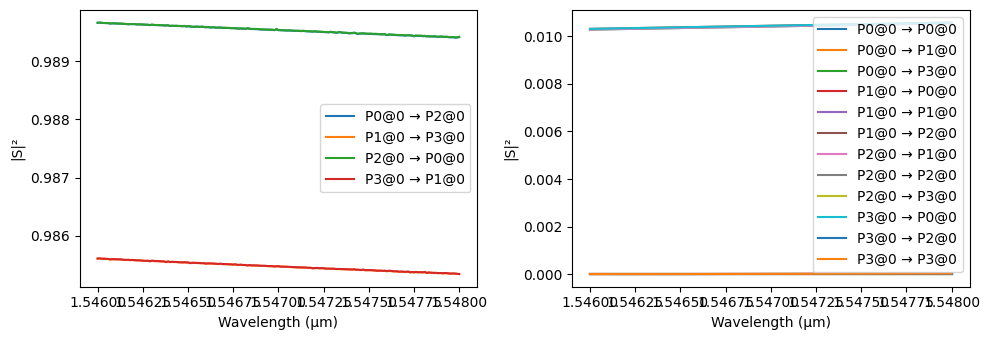

In [7]:
# Compute the S-matrix of the dual-ring coupler over the specified frequencies
s_matrix_dc = dc_coupler.s_matrix(frequencies)
_ = pf.plot_s_matrix(s_matrix_dc)

### Waveguide with Thermal Model

Next, we define the straight waveguide section and place a metal heater on top:

- We use a propagation loss, converted to an imaginary part of the refractive index (`kappa`) for accurate modeling.
- A heater is designed using a tapered metal path, consisting of wide pads and a narrow central section.
- This heater is positioned on top of the waveguide.
- We solve the port mode to get the base complex index and add loss by modifying the imaginary part.
- A custom `ThermalModel` is instantiated with this lossy refractive index, and added to the waveguide.
- Finally, we visualize the structure including the integrated heater.


In [8]:
# Set propagation loss in dB/cm
alpha = 10

# Define metal heater geometry
heater_width = 5
pad_width = 20
transition_length = 10

# Calculate imaginary part of refractive index due to propagation loss
kappa = (alpha * wavelengths * 1e-4 * np.log(10)) / (40 * np.pi)

# Create the waveguide geometry with length equal to the coupler
wg = pf.parametric.straight(length=coupling_length)

# Define the heater path with tapered metal pads and narrow central section
heater = (
    pf.Path((-2 * transition_length - pad_width, 0), pad_width)
    .segment((-2 * transition_length, 0), pad_width)
    .segment((-transition_length, 0), heater_width)
    .segment((coupling_length + transition_length, 0))
    .segment((coupling_length + 2 * transition_length, 0), pad_width)
    .segment((coupling_length + 2 * transition_length + pad_width, 0), pad_width)
)

# Attach the metal heater to the waveguide
wg.add((5, 0), heater)

# Solve for the port mode of the waveguide and extract the complex refractive index
mode_solver = pf.port_modes(port=wg.ports["P0"], frequencies=frequencies)
n_complex = mode_solver.data.n_complex.values.T + 1j * kappa  # add propagation loss

# Instantiate a thermal model using the lossy index
thermal_model = ThermalModel(n_complex=n_complex)

# Attach the thermal model to the waveguide
wg.add_model(thermal_model, "Thermal")

# Visualize the waveguide and heater
viewer(wg)

Loading cached simulation from /home/amin/.tidy3d/pf_cache/46K/ms_info-7CSE6OVQN7XOLHVSSUIKPCTYSPDKZIHYXXAZ56QVZLFEHH73PYBQ.json.
Progress: 100%


Before assembling the full circuit, we test the thermal model directly on the waveguide. We compute the S-matrix at `0 V` and `2 V` to observe the phase change. The phase shift of the `S21` response is plotted as a function of wavelength. This confirms that the custom thermal model applies a voltage-dependent phase shift, as expected.


Progress: 100% 
Progress: 100% 


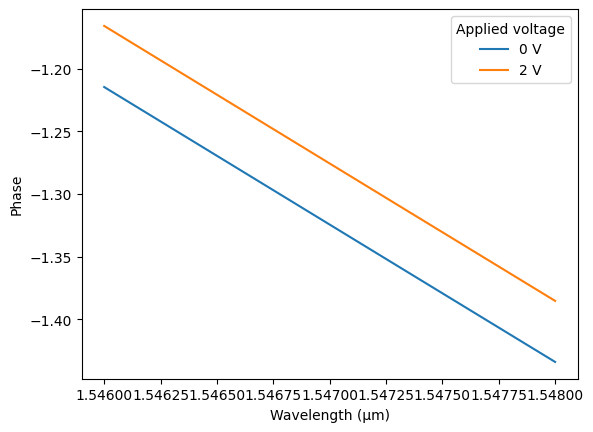

In [9]:
# Compute S-matrix for the waveguide with no voltage applied
s_v0 = wg.s_matrix(frequencies)

# Compute S-matrix with 2 V applied to the thermal model
s_v2 = wg.s_matrix(frequencies, model_kwargs={"voltage": 2})

# Plot the phase response (angle of S21) for both voltages
plt.plot(wavelengths, np.angle(s_v0[("P0@0", "P1@0")]), label="0 V")
plt.plot(wavelengths, np.angle(s_v2[("P0@0", "P1@0")]), label="2 V")

# Label the axes
plt.xlabel("Wavelength (µm)")
plt.ylabel("Phase")

# Add legend to differentiate voltage levels
plt.legend(title="Applied voltage")

# Display the plot
plt.show()


To ensure consistency across the layout, we also assign the same lossy refractive index to a waveguide bend:


In [10]:
# Create a bend waveguide using default parameters
bend = pf.parametric.bend(waveguide_model_kwargs={"n_complex": n_complex})

# Visualize the bend structure
viewer(bend)

### Tunable Microring Resonator Construction

We now build a tunable microring resonator by connecting the previously defined components:

- The `netlist` defines each component: a directional coupler (`dc`), a phase shifter (`ps`), and two bends (`b0` and `b1`).
- These components are connected in a loop to form the microring structure.
- External ports are exposed on the input and output sides of the directional coupler.
- A `CircuitModel` is assigned to handle simulation of the entire system.
- Finally, we use `component_from_netlist` to construct the full microring resonator.


In [11]:
# Define the netlist for a tunable microring resonator
netlist_mrr = {
    "name": "Tunable Microring Resonator",  # name of the component
    "instances": {
        "dc": dc_coupler,  # directional coupler
        "ps": wg,  # waveguide with heater (phase shifter)
        "b0": bend, 
        "b1": bend, 
    },
    # Define how components are connected
    "connections": [
        (("b0", "P1"), ("dc", "P1")),  # connect top bend to one side of the coupler
        (("b1", "P0"), ("dc", "P3")),  # connect bottom bend to the other side
        (("ps", "P0"), ("b0", "P0")),  # connect phase shifter to top bend
    ],
    # Define external ports (input and output)
    "ports": [("dc", "P0"), ("dc", "P2")],
    # Assign a CircuitModel to simulate the entire microring
    "models": [(pf.CircuitModel(), "Circuit")],
}

# Build the microring resonator from the netlist
mrr = pf.component_from_netlist(netlist_mrr)

# Visualize the resulting component
viewer(mrr)

Loading cached simulation from /home/amin/.tidy3d/pf_cache/5L2/ms_info-ZPLZ55UEP3XVIOWRGRNABXJX43I3RAY4M4HOWNXOOY3Q7SFUK5RQ.json.
Loading cached simulation from /home/amin/.tidy3d/pf_cache/LZF/ms_info-GH5Q5TCCAMHUKYUFIZIVMO42J7T2XM4PP64UY2X3ND3R224GFTHA.json.
Loading cached simulation from /home/amin/.tidy3d/pf_cache/KLM/ms_info-3VVYQBAJC6QKTL7KUFUGQF7YKGTDI6GOY5FPOHZNR5JJDAPM46XA.json.
Loading cached simulation from /home/amin/.tidy3d/pf_cache/WQE/ms_info-M2QEZSKM6GCJMK52QYYS723BPTTLFRLBC6FT5MK2C6YDALMTRFGQ.json.
Progress: 100% 


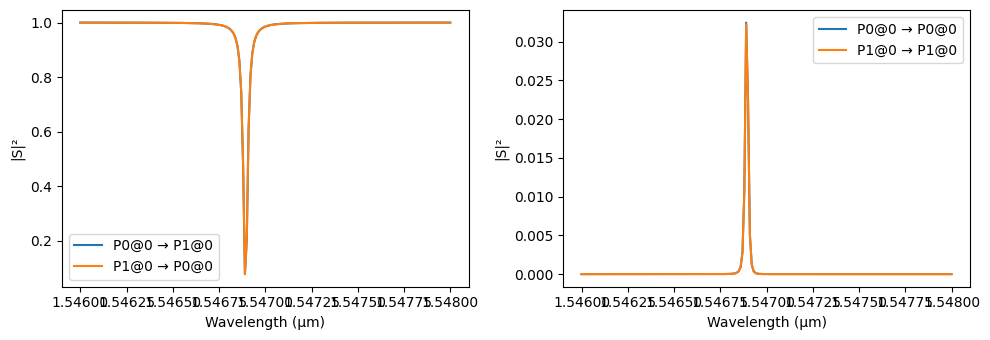

In [12]:
# Compute the S-matrix of the full circuit
s_matrix = mrr.s_matrix(frequencies)

# Plot transmission 
fig, ax = pf.plot_s_matrix(s_matrix)

### Resonance Tuning via Applied Voltage

To observe how the microring’s resonance shifts under different voltages:

- We sweep the applied voltage across the waveguide heater with values of `0 V`, `2 V`, and `3 V`.
- For each voltage, we simulate the S-matrix and extract the transmission (`S21`).
- The transmission spectra are plotted against wavelength in nanometers.
- The resonance shift is clearly visible, confirming the thermo-optic tuning effect of the microring.

> 💡 **Reference indexing**: When updating model parameters during S-matrix simulation, we use the syntax `(component_name, reference_index)`. This allows precise control when the same component appears multiple times within a larger layout. For example, `(wg.name, 0)` refers to the **first reference** of the `wg` component inside the `mrr`. If there were multiple uses of `wg`, we could address and update each independently by changing the index.


Progress: 100% 
Progress: 100% 
Progress: 100% 
Progress: 100% 


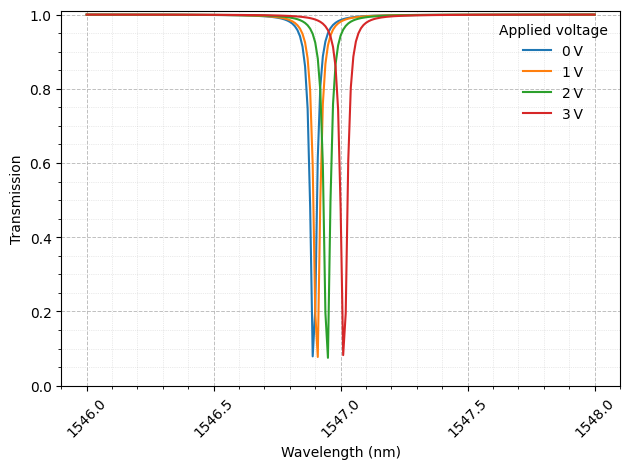

In [13]:
import matplotlib.ticker as ticker

# the list of voltages
voltages = [0, 1, 2, 3]

# make one figure/axes
fig, ax = plt.subplots()

for v in voltages:
    updates = {(wg.name, 0): {"model_updates": {"voltage": v}}}
    s_matrix = mrr.s_matrix(frequencies, model_kwargs={"updates": updates})
    s21 = s_matrix[("P0@0", "P1@0")]
    ax.plot(
        wavelengths * 1e3,
        np.abs(s21) ** 2,
        label=f"{v} V",
        linewidth=1.5,
    )

# labels & legend
ax.set_xlabel("Wavelength (nm)")
ax.set_ylabel("Transmission")
ax.set_ylim(0, 1.01)
ax.legend(title="Applied voltage", loc="upper right", frameon=False)

# major ticks every 0.5 nm, minor ticks every 0.1 nm
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))

# y‑axis major ticks every 0.2, minor every 0.05
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))

# enable both major & minor gridlines
ax.grid(which="major", linestyle="--", linewidth=0.7, alpha=0.8)
ax.grid(which="minor", linestyle=":", linewidth=0.5, alpha=0.5)

# rotate x‑labels for readability
plt.setp(ax.get_xticklabels(which="major"), rotation=45)

plt.tight_layout()
plt.show()